**データセットのインポートと確認**

kerasからデータセットをインポートする。（kerasはデータセットのダウンロードのほかにには使わない）



In [1]:
from keras.datasets import mnist



numpy、matplotlibのダウンロード


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

mnistデータセットを読み込む

In [3]:
(x_train, t_train), (x_test, t_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


データ型の確認

In [4]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


一番初めのデータの確認

In [5]:
img_0 = x_train[0]
label_0 = t_train[0]
print(label_0)

5


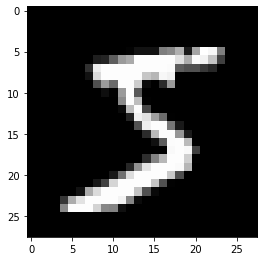

In [8]:
fig = plt.figure(figsize = (50,50))
image = fig.add_subplot(10,10,1)
image.imshow(img_0, cmap='gray')

データ型の変更

In [ ]:
x_train = x_train[:100]  #学習に使用するデータの個数は自由に変更できる
t_train = t_train[:100]
x_test = x_test[:50]
t_test = t_test[:50]
x_train = x_train.reshape(-1,1,28,28) #４次元にデータ型を変更する(-1とすると個数が合うように自動で調整してくれる)
x_test = x_test.reshape(-1,1,28,28)

きちんとデータ型が変更できているか確認

In [ ]:
print(x_train.shape)
print(x_test.shape)

(100, 1, 28, 28)
(50, 1, 28, 28)


**レイヤの作成**

まずはReLU

In [ ]:
class Relu:
  def __init__(self):
    self.mask = None

    
  def forward(self,x):
    self.mask = (x <= 0) 
    out = x.copy()         #とりあえず全てのxについてxを出力
    out[self.mask] = 0     #xが0以下の時は0を出力
     
    return out
  
  def backward(self,dout):
    dout[self.mask] = 0    #0以下の時は誤差も0
    dx = dout
    
    return dx

次はAffineレイヤ

In [ ]:
class Affine:            #テンソル対応 
  def __init__(self,W,b):
    self.W = W
    self.b = b
    
    self.x = None
    self.dW = None
    self.db = None

  def forward(self,x):
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0],-1)     #全結合層なので、行列に変形して計算する
    self.x = x
    
    out = np.dot(self.x,self.W) + self.b  #Affine変換
    
    return out
  
  def backward(self,dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    
    dx = dx.reshape(*self.original_x_shape) #元の形状に直す
    
    return dx

Softmaxレイヤ

In [ ]:
def softmax(x):   #まずはSoftmax関数を実装
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x,axis = 0)
    y = np.exp(x)/np.sum(np.exp(x), axis = 0)
    return y.T
  
  x = x - np.max(x)
  return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):  #損失関数の実装
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
    
  if t.size == y.size:
    t = t.argmax(axis=1)
    
    
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None   #softmaxの出力
    self.t = None   #教師データ
    
  def forward(self,x,t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)  #損失
    
    return self.loss
  
  def backward(self, dout):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
      
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size
      
    return dx

convolution層

In [ ]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
  #バッチ数まで含めた4次元配列を2次元配列に変換し、フィルターをかけやすいように入力データを変換する
  N, C, H, W = input_data.shape
  out_h = (H + 2*pad - filter_h)//stride + 1
  out_w = (W + 2*pad - filter_w)//stride + 1
  
  img = np.pad(input_data, [(0,0),(0,0),(pad,pad),(pad,pad)],'constant') #パディング
  col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

  for y in range(filter_h):
    y_max = y + stride*out_h
    for x in range(filter_w):
      x_max = x + stride*out_w
      col[:,:,y,x,:,:] = img[:,:,y:y_max:stride, x:x_max:stride]

  col = col.transpose(0,4,5,1,2,3).reshape(N*out_h*out_w, -1)
  return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
  #２次元配列を４次元に直す（逆伝搬）
  N, C, H, W = input_shape
  out_h = (H + 2*pad - filter_h)//stride + 1
  out_w = (W + 2*pad - filter_w)//stride + 1

  col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)
  img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))

  for y in range(filter_h):
    y_max = y + stride*out_h
    for x in range(filter_w):
      x_max = x + stride*out_w
      img[:, :, y:y_max:stride, x:x_max:stride] += col[:,:, y, x,:,:]

  return img[:,:, pad:H+pad, pad:W+pad] #４次元に直してreturn
  

In [ ]:
class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad
    
    self.x = None
    self.col = None
    self.col_W = None
    
    self.dW = None
    self.db = None

  def forward(self,x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
    out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

    col = im2col(x, FH, FW, self.stride, self.pad)
    col_W = self.W.reshape(FN, -1).T

    out = np.dot(col, col_W) + self.b
    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

    self.x = x
    self.col = col
    self.col_W = col_W

    return out
    
  def backward(self,dout):
    FN, C, FH, FW = self.W.shape
    dout = dout.transpose(0,2,3,1).reshape(-1, FN)

    self.db = np.sum(dout, axis=0)
    self.dW = np.dot(self.col.T, dout)
    self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

    dcol = np.dot(dout, self.col_W.T)
    dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

    return dx


Pooling層

In [ ]:
class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad
      
    self.x = None
    self.arg_max = None

  def forward(self, x):
    N, C, H, W = x.shape
    out_h = int(1 + (H - self.pool_h) / self.stride)
    out_w = int(1 + (W - self.pool_w) / self.stride)

    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
    col = col.reshape(-1, self.pool_h*self.pool_w)

    arg_max = np.argmax(col, axis=1)
    out = np.max(col, axis=1)
    out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

    self.x = x
    self.arg_max = arg_max

    return out

  def backward(self, dout):
    dout = dout.transpose(0, 2, 3, 1)
      
    pool_size = self.pool_h * self.pool_w
    dmax = np.zeros((dout.size, pool_size))
    dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
    dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
    dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
    dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
    return dx

Simple Convolution Networkの実装


In [ ]:
class SimpleConvNet:
  def __init__(self, input_dim=(1, 28, 28), 
               conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
               hidden_size=100, output_size=10, weight_init_std=0.01):
    filter_num = conv_param['filter_num']
    filter_size = conv_param['filter_size']
    filter_pad = conv_param['pad']
    filter_stride = conv_param['stride']
    input_size = input_dim[1]
    conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
    pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

    # 重みの初期化
    self.params = {}
    self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)

    # レイヤの生成
    self.layers = OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                       conv_param['stride'], conv_param['pad'])
    self.layers['Relu1'] = Relu()
    self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
    self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

    self.last_layer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  def loss(self, x, t):
    y = self.predict(x)
    return self.last_layer.forward(y, t)

  def accuracy(self, x, t, batch_size=100):
    if t.ndim != 1 : t = np.argmax(t, axis=1)
        
    acc = 0.0
        
    for i in range(int(x.shape[0] / batch_size)):
      tx = x[i*batch_size:(i+1)*batch_size]
      tt = t[i*batch_size:(i+1)*batch_size]
      y = self.predict(tx)
      y = np.argmax(y, axis=1)
      acc += np.sum(y == tt) 
        
    return acc / x.shape[0]

  def numerical_gradient(self, x, t):
        
    loss_w = lambda w: self.loss(x, t)

    grads = {}
    for idx in (1, 2, 3):
      grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
      grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

    return grads

  def gradient(self, x, t):
        
    # forward
    self.loss(x, t)

    # backward
    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    # 設定
    grads = {}
    grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
    grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

    return grads
        
  def save_params(self, file_name="params.pkl"):
    params = {}
    for key, val in self.params.items():
      params[key] = val
    with open(file_name, 'wb') as f:
      pickle.dump(params, f)

  def load_params(self, file_name="params.pkl"):
    with open(file_name, 'rb') as f:
      params = pickle.load(f)
    for key, val in params.items():
      self.params[key] = val

    for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
      self.layers[key].W = self.params['W' + str(i+1)]
      self.layers[key].b = self.params['b' + str(i+1)]


In [ ]:
class SGD:

  def __init__(self, lr=0.01):
    self.lr = lr
        
  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key] 
            
class Momentum:

  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None
        
  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():                                
        self.v[key] = np.zeros_like(val)
                
    for key in params.keys():
      self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
      params[key] += self.v[key]


class Nesterov:
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None
        
  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)
            
    for key in params.keys():
      self.v[key] *= self.momentum
      self.v[key] -= self.lr * grads[key]
      params[key] += self.momentum * self.momentum * self.v[key]
      params[key] -= (1 + self.momentum) * self.lr * grads[key]

class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None
        
  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)
            
    for key in params.keys():
      self.h[key] += grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:
  def __init__(self, lr=0.01, decay_rate = 0.99):
    self.lr = lr
    self.decay_rate = decay_rate
    self.h = None
        
  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)
          
    for key in params.keys():
      self.h[key] *= self.decay_rate
      self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:
  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None
        
  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = {}, {}
      for key, val in params.items():
        self.m[key] = np.zeros_like(val)
        self.v[key] = np.zeros_like(val)
        
    self.iter += 1
    lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
    for key in params.keys():
      self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
      self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
      params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
     

In [ ]:
max_epochs = 20
class Trainer:
  def __init__(self, network, x_train, t_train, x_test, t_test,
               epochs=20, mini_batch_size=100,
               optimizer='SGD', optimizer_param={'lr':0.01}, 
               evaluate_sample_num_per_epoch=None, verbose=True):
    self.network = network
    self.verbose = verbose
    self.x_train = x_train
    self.t_train = t_train
    self.x_test = x_test
    self.t_test = t_test
    self.epochs = epochs
    self.batch_size = mini_batch_size
    self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

    # optimizer
    optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                            'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
    self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
      
    self.train_size = x_train.shape[0]
    self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
    self.max_iter = int(epochs * self.iter_per_epoch)
    self.current_iter = 0
    self.current_epoch = 0
    self.train_loss_list = []
    self.train_acc_list = []
    self.test_acc_list = []
  
  def train_step(self):
    batch_mask = np.random.choice(self.train_size, self.batch_size)
    x_batch = self.x_train[batch_mask]
    t_batch = self.t_train[batch_mask]
        
    grads = self.network.gradient(x_batch, t_batch)
    self.optimizer.update(self.network.params, grads)
        
    loss = self.network.loss(x_batch, t_batch)
    self.train_loss_list.append(loss)
    if self.verbose: print("train loss:" + str(loss))
        
    if self.current_iter % self.iter_per_epoch == 0:
      self.current_epoch += 1
            
      x_train_sample, t_train_sample = self.x_train, self.t_train
      x_test_sample, t_test_sample = self.x_test, self.t_test
      if not self.evaluate_sample_num_per_epoch is None:
        t = self.evaluate_sample_num_per_epoch
        x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
        x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
      train_acc = self.network.accuracy(x_train_sample, t_train_sample)
      test_acc = self.network.accuracy(x_test_sample, t_test_sample)
      self.train_acc_list.append(train_acc)
      self.test_acc_list.append(test_acc)

      if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
    self.current_iter += 1

    
  def train(self):
    for i in range(self.max_iter):
      self.train_step()

    test_acc = self.network.accuracy(self.x_test, self.t_test)

    if self.verbose:
      print("=============== Final Test Accuracy ===============")
      print("test acc:" + str(test_acc))


In [ ]:
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer.train()

train loss:1.8308182970921993
=== epoch:1, train acc:0.48, test acc:0.0 ===
train loss:1.5121682382425146
=== epoch:2, train acc:0.74, test acc:0.0 ===
train loss:1.2092475146343398
=== epoch:3, train acc:0.74, test acc:0.0 ===
train loss:0.6600481166233558
=== epoch:4, train acc:0.85, test acc:0.0 ===
train loss:0.3674201984839855
=== epoch:5, train acc:0.88, test acc:0.0 ===
train loss:0.32738419316074235
=== epoch:6, train acc:0.92, test acc:0.0 ===
train loss:0.16944364969111014
=== epoch:7, train acc:0.95, test acc:0.0 ===
train loss:0.11460473022555805
=== epoch:8, train acc:0.93, test acc:0.0 ===
train loss:0.06746140659037256
=== epoch:9, train acc:1.0, test acc:0.0 ===
train loss:0.10555087655946624
=== epoch:10, train acc:0.95, test acc:0.0 ===
train loss:0.07834445361720224
=== epoch:11, train acc:0.97, test acc:0.0 ===
train loss:0.0367257481850791
=== epoch:12, train acc:0.99, test acc:0.0 ===
train loss:0.01640955153319947
=== epoch:13, train acc:0.99, test acc:0.0 ===
tr

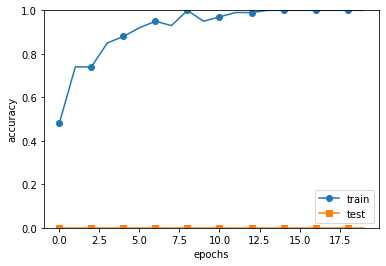

In [ ]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
